<a href="https://colab.research.google.com/github/yishak-cs/VariationalAutoEncoder/blob/main/VariationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VARIATIONAL AUTOENCODER (VAE) FOR MNIST DIGIT GENERATION

This project implements a Variational Autoencoder to learn a compressed representation
of handwritten digits from the MNIST dataset. The VAE can:

1. Compress 28x28 digit images (784 pixels) into a 2D latent space
2. Reconstruct original images from the compressed representation
3. Generate new digit-like images by sampling from the learned latent space
4. Visualize how different regions of the latent space correspond to different digits

The model learns to encode digits into a 2D space where similar digits cluster together,
allowing for smooth interpolation between different digit types.

In [19]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

### DATA PREPARATION
Load MNIST dataset and create data loaders for training and testing

In [20]:
# prepare data
transform = transforms.Compose([transforms.ToTensor()])
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, train=False, download=True)

batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### VAE MODEL ARCHITECTURE
* Encoder: 784 → 512 → 2D latent space (mean & variance)
* Decoder: 2D latent space → 512 → 784 (reconstructed image)

In [21]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=2, device=device):
        super(VAE, self).__init__()

        # Encoder: 784 -> 512 -> latent_dim -> 2
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2)
        )

        # Latent space: Output mean and log-variance for 2D latent variables
        # This creates a probabilistic encoding instead of deterministic
        self.mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        # Decoder: 2 -> 512 -> 784
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mean = self.mean_layer(h)
        logvar = self.logvar_layer(h)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        # Convert log_var to std: std = exp(0.5 * log_var)
        std = torch.exp(0.5 * logvar)
        # Sample epsilon from standard normal
        epsilon = torch.randn_like(std).to(device)
        # Return z = mean + std * epsilon
        return mean + std * epsilon

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

VAE LOSS FUNCTION
* Combines reconstruction loss (how well we rebuild the image) with KL divergence loss (how close our latent distribution is to standard normal)

In [22]:
def loss_function(x, x_hat, mean, log_var):
    # reconstruction loss: how well can we reconstruct the input
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    # KL divergence loss: how far is our distribution from N(0,1)?
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [23]:
def train_epoch(model, train_loader, optimizer, device):
    """Train for one epoch and return average loss"""
    model.train()  # Set to training mode
    total_loss = 0
    total_samples = 0

    for batch_idx, (x, _) in enumerate(train_loader):
        # Flatten images: (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(x.size(0), -1).to(device)

        # Forward pass
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)

        # Calculate loss
        loss = loss_function(x, x_hat, mean, log_var)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track statistics
        total_loss += loss.item()
        total_samples += x.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss

 Evaluate model on test set using Mean Squared Error for reconstruction

In [24]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set to evaluation mode
    total_mse = 0
    total_samples = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.view(x.size(0), -1).to(device)

            # Forward pass
            x_hat, _, _ = model(x)

            # Calculate Mean Squared Error for reconstruction
            mse = nn.functional.mse_loss(x_hat, x, reduction='sum')

            total_mse += mse.item()
            total_samples += x.size(0)

    avg_mse = total_mse / total_samples
    return avg_mse

In [28]:
def train_vae(model, train_loader, optimizer, epochs, device):
    """Complete training loop without test set evaluation"""
    train_losses = []

    print("Starting VAE Training...")
    print("=" * 50)

    for epoch in range(epochs):
        # Train for one epoch
        train_loss = train_epoch(model, train_loader, optimizer, device)

        # Store losses
        train_losses.append(train_loss)

        # Print progress
        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {train_loss:.2f}")

    print("=" * 50)
    print("Training completed!")

    return train_losses

Starting VAE Training...
Epoch  1/20 | Train Loss: 175.79
Epoch  2/20 | Train Loss: 159.61
Epoch  3/20 | Train Loss: 155.93
Epoch  4/20 | Train Loss: 153.72
Epoch  5/20 | Train Loss: 152.37
Epoch  6/20 | Train Loss: 151.22
Epoch  7/20 | Train Loss: 150.37
Epoch  8/20 | Train Loss: 149.68
Epoch  9/20 | Train Loss: 149.06
Epoch 10/20 | Train Loss: 148.39
Epoch 11/20 | Train Loss: 147.96
Epoch 12/20 | Train Loss: 147.47
Epoch 13/20 | Train Loss: 147.11
Epoch 14/20 | Train Loss: 146.94
Epoch 15/20 | Train Loss: 146.46
Epoch 16/20 | Train Loss: 146.21
Epoch 17/20 | Train Loss: 145.88
Epoch 18/20 | Train Loss: 145.90
Epoch 19/20 | Train Loss: 145.56
Epoch 20/20 | Train Loss: 145.18
Training completed!


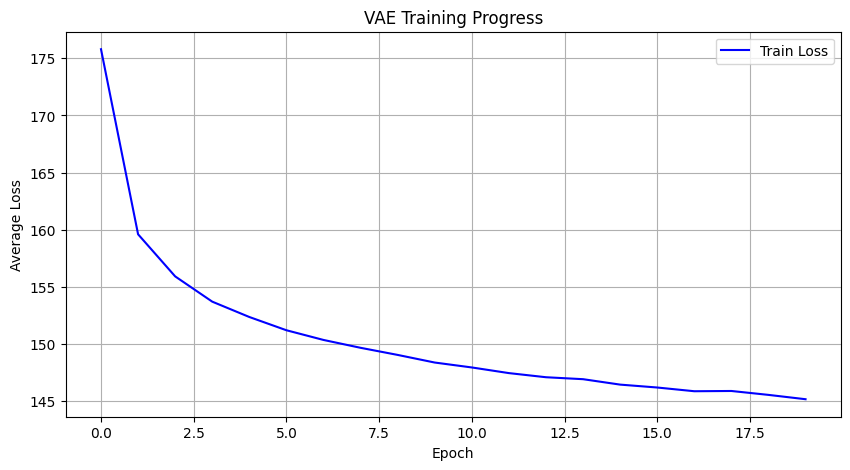


Test Reconstruction Loss (MSE): 146.6789


In [33]:
# Create model
model = VAE(input_dim=784, hidden_dim=512, latent_dim=2).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

# Train model
train_losses = train_vae(model, train_loader, optimizer,
                                     epochs=20, device=device)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('VAE Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the trained model on the test set separately
test_reconstruction_loss = evaluate_model(model, test_loader, device)
print(f"\nTest Reconstruction Loss (MSE): {test_reconstruction_loss:.4f}")

In [34]:
def generate_digit(model, mean, var):
    """Generate a digit from specific latent coordinates"""
    model.eval()
    with torch.no_grad():
        z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
        x_decoded = model.decode(z_sample)
        digit = x_decoded.detach().cpu().reshape(28, 28)

        plt.figure(figsize=(3, 3))
        plt.title(f'Generated from z=[{mean:.1f}, {var:.1f}]')
        plt.imshow(digit, cmap='gray')
        plt.axis('off')
        plt.show()

In [40]:
def plot_latent_space(model, scale=2.0, n=15, digit_size=28, figsize=10):
    """Visualize the learned latent space"""
    model.eval()
    figure = np.zeros((digit_size * n, digit_size * n))

    # Create grid of latent coordinates
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
                x_decoded = model.decode(z_sample)
                digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
                figure[i * digit_size:(i + 1) * digit_size,
                       j * digit_size:(j + 1) * digit_size] = digit.numpy() # Convert to NumPy array

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')

    # Add coordinate labels
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("Latent Dimension 1 (z[0])")
    plt.ylabel("Latent Dimension 2 (z[1])")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


Testing the trained model:
------------------------------


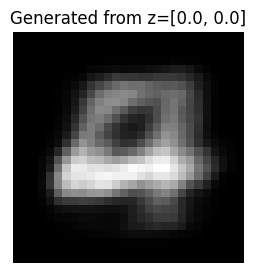

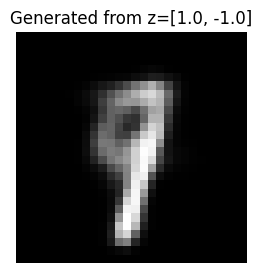

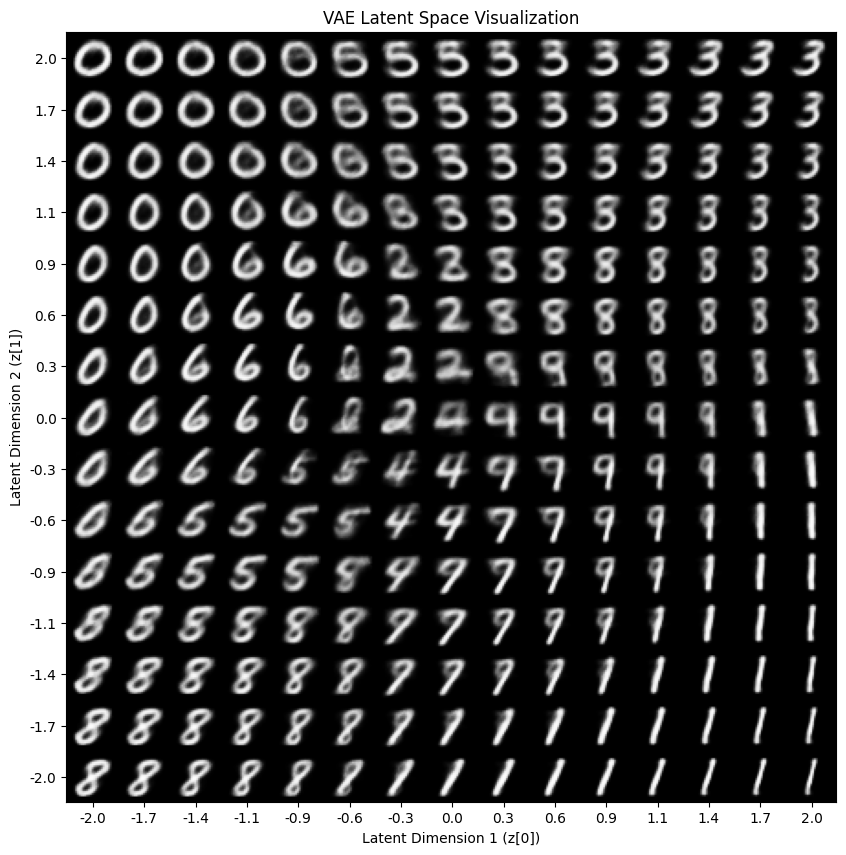

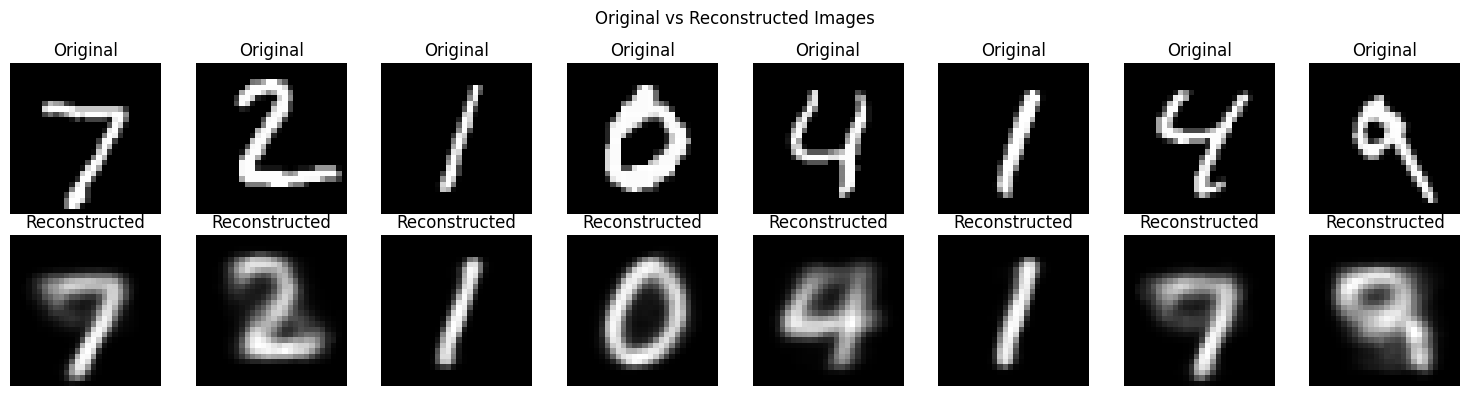

In [39]:
def plot_reconstructions(model, test_loader, device, n_samples=8):
    """Show original vs reconstructed images"""
    model.eval()

    # Get a batch of test data
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.view(x.size(0), -1).to(device)
            x_hat, _, _ = model(x)

            # Take first n_samples
            x = x[:n_samples].cpu().reshape(-1, 28, 28)
            x_hat = x_hat[:n_samples].cpu().reshape(-1, 28, 28)

            # Plot comparison
            fig, axes = plt.subplots(2, n_samples, figsize=(15, 4))
            fig.suptitle('Original vs Reconstructed Images')

            for i in range(n_samples):
                # Original
                axes[0, i].imshow(x[i], cmap='gray')
                axes[0, i].set_title('Original')
                axes[0, i].axis('off')

                # Reconstructed
                axes[1, i].imshow(x_hat[i], cmap='gray')
                axes[1, i].set_title('Reconstructed')
                axes[1, i].axis('off')

            plt.tight_layout()
            plt.show()
            break

# Test the trained model
print("\nTesting the trained model:")
print("-" * 30)

# Generate specific digits
generate_digit(model, 0.0, 0.0)
generate_digit(model, 1.0, -1.0)

# Plot latent space
plot_latent_space(model, scale=2.0)

# Show reconstructions
plot_reconstructions(model, test_loader, device)

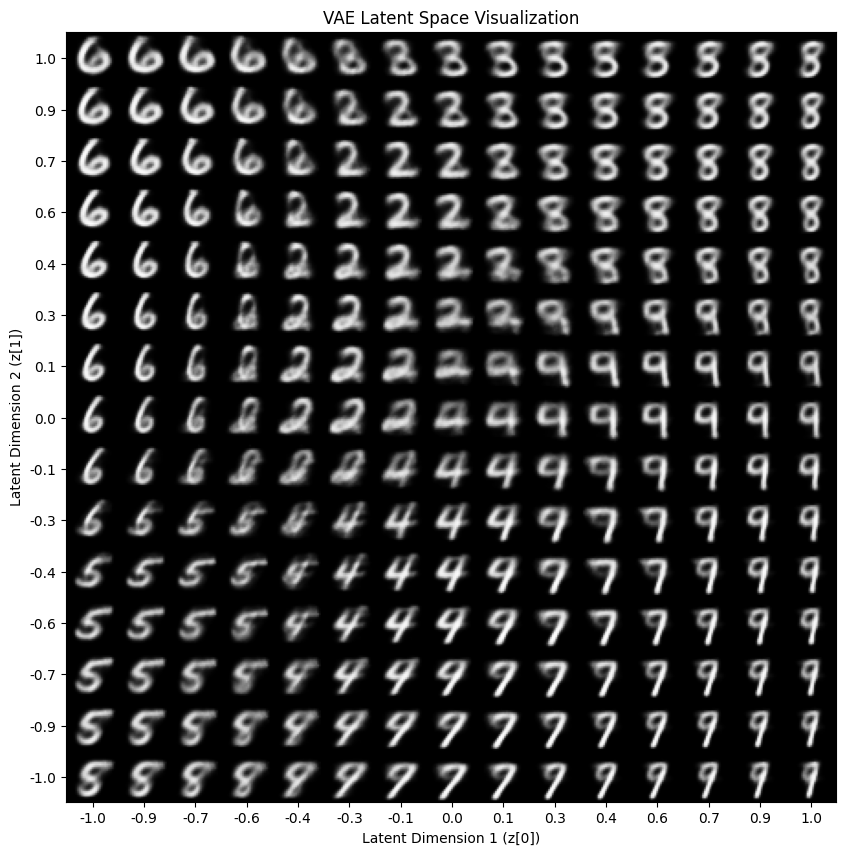

In [41]:
plot_latent_space(model, scale=1.0)